# **Name:** Subhadeep Chaudhuri | **Roll no.** : 19i190010

### **Question 2:** Bandit Setting

Algorithms considered: EXP3, EXP3-P, EXP3-IX

In [ ]:
###########################################
## Importing the necessary packages
###########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import scipy.stats as ss
import copy
from tqdm import tqdm

In [ ]:
###############################
## Different algorithm types
###############################
EXP3 = 1
EXP3_P = 2
EXP3_IX = 3

In [ ]:
#############################################################################################
## Method to compute the first term in the expression of pseudo-regret
## Input: Horizon T, delta for the distribution, the arms selected in each round till time T
#############################################################################################
def mean_losses(T, delta, arms):
    means_array_slot1 = [0.5 for _ in range(8)]
    means_array_slot2 = copy.deepcopy(means_array_slot1)
    means_array_slot1.extend([0.5-delta, 0.5+delta])
    means_array_slot2.extend([0.5-delta, 0.5-2*delta])
    
    arms_slot_1 = arms[:int(len(arms)/2)]
    arms_slot_2 = arms[int(len(arms)/2):]
    
    observed_means_slot1 = np.array([means_array_slot1[i] for i in arms_slot_1])
    observed_means_slot2 = np.array([means_array_slot2[i] for i in arms_slot_2])
    
    return np.sum(observed_means_slot1) + np.sum(observed_means_slot2) 


In this block, we define the main implementation. It is such that it computes the regret for all the 3 types of algorithms depending on an additional argument that states the algorithm type. 

- **Inputs to the algorithm:**
> - Algorithm type: argument corresponding to EXP3, EXP3-P or EXP3-IX
> - Horizon $T$, 
> - Number of arms $k$
> - $\Delta$ for specifying the probability distribution governing the losses
> - $c$ which will be used to calculate the learning rate $\eta = c\sqrt{\frac{2log(d)}{kT}}$

- We create a loss matrix of shape $T \times d$, where the $i^{th}$ row denotes the losses of the $k$ arms at time round $i$. We create the entire loss matrix at once to reduce complexity of the algorithm.
- **Output:** Pseudo Regret of the algorithm, $R(T) = \sum_{t=1}^{T}\mu_t^{I_t} - \min_{i}\sum_{t=1}^{T}\mu_t^{i}$ 

In [ ]:
################################################
## Implementing the main algorithm
## Algorithm choices: EXP3, EXP3_P, EXP3_IX
################################################

def algorithm(algo_type, T, k, delta, c):
    
    ## Creating a loss matrix of size (T x d)
    ## i-th row denoting loss of all experts in i-th round 
    #######################################################
    loss = np.zeros((T, k))
    for i in range(T):
        loss[i][0:-2] = np.random.binomial(n=1, p = 0.5, size = k-2)              ## For the first 8 arms 
        loss[i][-2] = np.random.binomial(n=1, p = 0.5-delta, size = 1)            ## For the 9-th arm
        if i < T/2:
            loss[i][-1] = np.random.binomial(n=1, p = 0.5+delta, size = 1)        ## For the 10-th arm when t <= T/2
        else:
            loss[i][-1] = np.random.binomial(n=1, p = 0.5-2*delta, size = 1)      ## For the 10-th arm when t > T/2
    
    ## Initializing and creating necessary variables
    #######################################################
    eta = c*np.sqrt(2*np.log(k)/(k*T))     ## Learning rate eta 
    total_loss = 0                         ## Variable to store total cost incurred throughout
    L = np.zeros(k)                        ## Array to store L_hat. Gets updated in each round
    arms = [i for i in range(k)]           ## List of indices corresponding to each of the K arms
    chosen_arms = []                       ## List to store the arms selected in each round by the algorithm
    if algo_type == EXP3_P:                ## Requirements for EXP3_P
        gamma = k*eta  
        beta = eta
    elif algo_type == EXP3_IX:             ## Requirements for EXP3_IX
        gamma = eta/2
    
    ## Iteration over time. Main loop of the algorithm
    #######################################################
    for t in range(T):
        if algo_type == EXP3:                                  ############### Implementation for Exp3 algorithm ###############
            l_t_hat = np.zeros(k)
            p_t = np.divide(np.exp(-eta*L), np.sum(np.exp(-eta*L)))         ## Probability vector
            I_t = np.random.choice(arms, p = p_t)                           ## Selection of arm I_t in round t w.ith associated probability P_t 
            l_t = loss[t][I_t]                                              ## Loss observed due to selection of arm I_t
            total_loss += l_t                                               ## Summing up observed losses over rounds
            l_t_hat[I_t] = l_t/p_t[I_t]
            L += l_t_hat
            chosen_arms.append(I_t)                                         ## Appending the chosen arm in round t
        elif algo_type == EXP3_P:                            ################# Implementation for Exp3_P algorithm ###############
            l_t_hat = np.zeros(k)
            p_t = np.multiply((1-gamma),np.divide(np.exp(-eta*L), np.sum(np.exp(-eta*L)))) + (gamma/k)
            I_t = np.random.choice(arms, p = p_t)
            l_t = loss[t][I_t]
            total_loss += l_t
            l_t_hat[I_t] = (l_t + beta)/p_t[I_t]
            L += l_t_hat
            chosen_arms.append(I_t)
        elif algo_type == EXP3_IX:                           ################# Implementation for Exp3_IX algorithm ###############
            l_t_hat = np.zeros(k)
            # p_t = np.multiply((1-gamma),np.divide(np.exp(-eta*L), np.sum(np.exp(-eta*L)))) 
            p_t = np.divide(np.exp(-eta*L), np.sum(np.exp(-eta*L)))
            I_t = np.random.choice(arms, p = p_t)
            l_t = loss[t][I_t]
            total_loss += l_t
            l_t_hat[I_t] = l_t /(p_t[I_t]+gamma)
            L += l_t_hat
            chosen_arms.append(I_t)

    total_expected_loss = mean_losses(T, delta, chosen_arms)                                      ## Computes the first term in the definition of pseudo regret
    best_arm_loss = np.min([T*0.5, T*(0.5-delta), ((T*(0.5+delta)/2)+(T*(0.5-(2*delta))/2))])     ## Computes the 2nd term in the definition of pseudo regret
    
    regret = total_expected_loss - best_arm_loss            ## Pseudo regret

    return regret

This method implements the desired algorithm over multiple runs. The regret obtained from each run of the algorithm are then stored in an array for further use.

In [ ]:
##################################################################
## Method to call the different algorithm over multiple runs
## Algorithm choices: EXP3, EXP3_P, EXP3_IX
##################################################################

def algo_over_runs(runs, *args):

    ## Checking the validity of the arguments required in weighted_majority algorithm
    #################################################################################
    if args is None:
        err_msg = 'Arguments are missing. Check again!'
        raise ValueError(err_msg)
    elif len(args) < 5 :
        err_msg = 'Minimum arguments not given. Check again!'
        raise ValueError(err_msg)
    else:
        algo_type = args[0]
        T = args[1]
        k = args[2]
        delta = args[3]
        c = args[4]

    ## Storing the regret obtained for each run in an array
    #######################################################
    regret_array = np.zeros(runs)
    for i in range(runs):
        regret_array[i] = algorithm(algo_type, T, k, delta, c)     ## Looping over runs and storing the regret in each run
    
    return regret_array

This method is used to obtain the average regrets over multiple runs along with 95% confidence intervals for different choices of $c$ i.e. for different learning rates $\eta$ corresponding to the desired algorithm type.

In [ ]:
###################################################################################
## Method to store the mean regret for each choice of eta for the chosen algorithm 
## Algorithm choices: EXP3, EXP3_P, EXP3_IX
###################################################################################

def algo_over_all(runs, algo_type, T, k, delta, c_array):

    ## Calculating the average regret over many runs for each eta
    ## 95% CI are to be created. So we store the error terms as well
    ##################################################################
    mean_regret_array = []
    regret_error = []
    for i in tqdm(range(len(c_array))):                                              ## Looping over all the choices of c, i.e. different eta
        regret_array_c =  algo_over_runs(runs, algo_type, T, k, delta, c_array[i])
        mean_regret_array.append(np.mean(regret_array_c))                            ## Storing the mean regrets over multiple runs
        regret_error.append(ss.t.ppf(0.95, df = runs -1)*ss.sem(regret_array_c))     ## Storing the standard error over multiple runs for the 95% CI

    return np.array(mean_regret_array), np.array(regret_error)

This method is used to obtain the plots showing the average regrets over multiple runs along with 95% confidence intervals for different choices of $c$ i.e. for different learning rates $\eta$ corresponding to each of the algorithm types EXP3, EXP3.P and EXP3-IX.

We call each of the algorithm types using "algo_over_all" and store it in some arrays, which are then plotted. 

In [ ]:
###########################################################################################
## Method to plot the 95% CIs of the average regrets for each algorithm for different eta
###########################################################################################

def main_plot_function(runs, *args):

    ## Checking the validity of the arguments required in weighted_majority algorithm
    #################################################################################
    if args is None:
        err_msg = 'No arguments given. Cannot plot!'
        raise ValueError(err_msg)
    elif len(args) < 4 :
        err_msg = 'Insufficient arguments. Check again!'
        raise ValueError(err_msg)
    else:
        T = args[0]
        k = args[1]
        delta = args[2]
        c_array = args[3]

    mean_regret_array_EXP3, regret_error_EXP3 = algo_over_all(runs, EXP3, T, k, delta, c_array)              ## Storing the mean regrets for EXP3 algo 
    mean_regret_array_EXP3_P,  regret_error_EXP3_P = algo_over_all(runs, EXP3_P, T, k, delta, c_array)       ## Storing the mean regrets for EXP3_P algo
    mean_regret_array_EXP3_IX, regret_error_EXP3_IX = algo_over_all(runs, EXP3_IX, T, k, delta, c_array)     ## Storing the mean regrets for EXP3_IX algo

    eta_array = c_array*np.sqrt(2*np.log(k)/(k*T))                                                           ## Eta array for all possible choices of c
    
    ## Plotting the regret for each eta along with the 95% CI
    ###############################################################
    plt.errorbar(eta_array, mean_regret_array_EXP3, regret_error_EXP3, marker = 'o', color = 'red', label = 'EXP3')
    plt.fill_between(eta_array, mean_regret_array_EXP3 - regret_error_EXP3, mean_regret_array_EXP3 + regret_error_EXP3, color='red', alpha=0.1)
    plt.title(f'Pseudo Regret Plot for Bandit Setting\n (T = {T}, runs = {runs})', fontweight = 'bold')
    plt.xlabel('Learning Rate ($\eta$)')
    plt.ylabel('(Pseudo) Regret')
    plt.errorbar(eta_array, mean_regret_array_EXP3_P, regret_error_EXP3_P, marker = '*', color = 'blue', label = 'EXP3_P')
    plt.fill_between(eta_array, mean_regret_array_EXP3_P - regret_error_EXP3_P, mean_regret_array_EXP3_P + regret_error_EXP3_P, color='blue', alpha=0.1)
    plt.errorbar(eta_array, mean_regret_array_EXP3_IX, regret_error_EXP3_IX, marker = '+', color = 'green', label = 'EXP3_IX')
    plt.fill_between(eta_array, mean_regret_array_EXP3_IX - regret_error_EXP3_IX, mean_regret_array_EXP3_IX + regret_error_EXP3_IX, color='green', alpha=0.1)
    plt.legend(title = 'Algorithm')
    plt.savefig('q2.png')
    plt.show()
    return [mean_regret_array_EXP3, mean_regret_array_EXP3_P, mean_regret_array_EXP3_IX], [regret_error_EXP3, regret_error_EXP3_P, regret_error_EXP3_IX]

These are the parameters of the problem, as given in the question. We average out the regret over 50 runs, with the horizon taken as $10^5$

In [ ]:
###########################################
## Parameters for the problem
###########################################
delta = 0.1  ## Parameter of distribution of loss for environment
T = 100000   ## Horizon
k = 10       ## No. of experts
c_array = np.arange(0.1, 2.11, 0.2).astype(np.double).round(2)
runs = 60    ## No. of runs

100%|██████████| 11/11 [1:11:30<00:00, 390.02s/it]


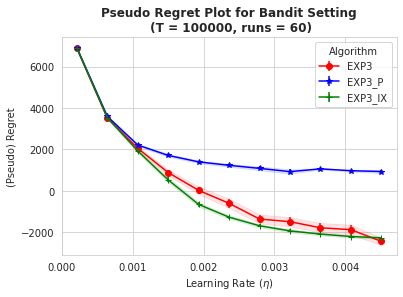

In [ ]:
avg_regrets, bar_widths = main_plot_function(runs, T, k, delta, c_array)